In [1]:
!pip install eli5
import pandas as pd
import seaborn as sns
import eli5
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import nltk
# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = stopwords.words("english")

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

     |████████████████████████████████| 216 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 57.9 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=7bb592ca9b6c2a52491082e8fbd3f18cb6f0ce27bc8ba16ac6b5e12ad1ba3e76
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping c

In [2]:
reviews = pd.read_csv('reviews.csv')
reviews = reviews[['reviewid', 'score']]
reviews.head()

,reviewid,score
0,22703,9.3
1,22721,7.9
2,22659,7.3
3,22661,9.0
4,22725,8.1


In [3]:
reviews.shape

(18393, 2)

In [4]:
content = pd.read_csv('content.csv')
content.head()

,reviewid,content
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


In [5]:
df = pd.merge(content, reviews, on='reviewid').drop('reviewid', axis=1)

In [6]:
df.isna().any()

content     True
score      False
dtype: bool

In [7]:
df = df.drop(df[df['content'].isna()].index)

In [8]:
df.head()

,content,score
0,"“Trip-hop” eventually became a ’90s punchline,...",9.3
1,"Eight years, five albums, and two EPs in, the ...",7.9
2,Minneapolis’ Uranium Club seem to revel in bei...,7.3
3,Kleenex began with a crash. It transpired one ...,9.0
4,It is impossible to consider a given release b...,8.1


In [9]:
df.shape

(18391, 2)

In [10]:
df.to_csv('content_scores.csv')

## CLASSIFICATION

In [11]:
df = pd.read_csv('content_scores.csv')

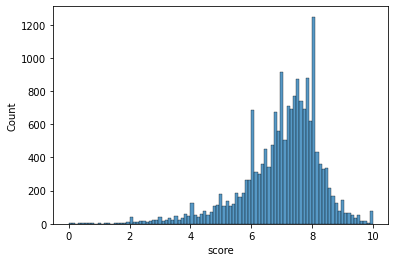

In [12]:
sns.histplot(df['score']);


In [13]:
df['score'] = df['score'].map(lambda x: 1 if x > 7 else 0)

In [14]:
values = df.score.value_counts()
values

1    10313
0     8078
Name: score, dtype: int64

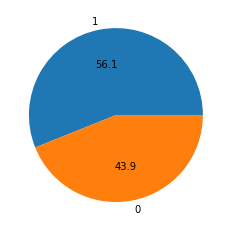

In [15]:
plt.pie(values, labels=values.keys(), autopct='%.1f');

In [16]:
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords_list)),
                 ('logit', LogisticRegression(n_jobs=-1))])

In [17]:
%%time
pipe.fit(df['content'], df['score'])

CPU times: user 9.95 s, sys: 239 ms, total: 10.2 s
Wall time: 17.9 s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logit', LogisticRegression(n_jobs=-1))])

In [18]:
weights = eli5.sklearn.explain_linear_classifier_weights(clf=pipe.named_steps['logit'],
                                                         vec=pipe.named_steps['tfidf'],
                                                         top=None
                                                         )

In [19]:
weights_df = eli5.formatters.as_dataframe.format_as_dataframe(weights)
weights_df = weights_df.drop(columns=['target'])
weights_df.head()

,feature,weight
0,music,3.130468
1,reissue,2.353367
2,also,2.350731
3,simple,2.269891
4,jazz,2.258805


In [40]:
weights_df.iloc[1]

feature     reissue
weight     2.353367
Name: 1, dtype: object

In [20]:
weights_df.to_csv('weights.csv')

## CORPUS

In [21]:
weights_df.shape

(122363, 2)

In [22]:
weights_df.semantic = weights_df.weight.apply(lambda weight: 1 if weight > 0 else 0)

In [23]:
semantic_counts = weights_df.semantic.value_counts()
semantic_counts

1    68555
0    53808
Name: weight, dtype: int64

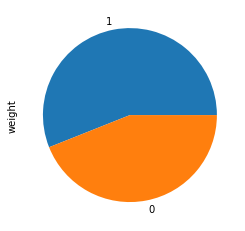

In [24]:
semantic_counts.plot(kind='pie');

In [126]:
df1 = pd.DataFrame({'feature': [], 'weight': []})

In [175]:
df2 = pd.DataFrame({'feature': [], 'weight': [], 'tag': [], 'sem_group': []})

In [159]:
nltk.download('averaged_perceptron_tagger')
import numpy as np

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [130]:
for i in range (122363):
  if (weights_df['weight'][i] <= -0.5) or (weights_df['weight'][i] >= 0.5):
    df1 = df1.append(weights_df.iloc[i])
df1

,feature,weight
0,music,3.130468
1,reissue,2.353367
2,also,2.350731
3,simple,2.269891
4,jazz,2.258805
...,...,...
122358,worse,-3.388494
122359,decent,-3.451536
122360,least,-4.591881
122361,unfortunately,-5.714797


In [160]:
df1.index = np.arange(len(df1))
df1

,feature,weight
0,music,3.130468
1,reissue,2.353367
2,also,2.350731
3,simple,2.269891
4,jazz,2.258805
...,...,...
2291,worse,-3.388494
2292,decent,-3.451536
2293,least,-4.591881
2294,unfortunately,-5.714797


In [176]:
for i in range (2296):
    if (nltk.pos_tag(df1['feature'])[i][1] == 'JJ') or (nltk.pos_tag(df1['feature'])[i][1] == 'JJR') or (nltk.pos_tag(df1['feature'])[i][1] == 'JJS') or (nltk.pos_tag(df1['feature'])[i][1] == 'RB') or (nltk.pos_tag(df1['feature'])[i] == 'RBR') or (nltk.pos_tag(df1['feature'])[i][1] == 'RBS'):
      df2 = df2.append(df1.iloc[i])
      df2['tag'][i] = nltk.pos_tag(df1['feature'])[i][1]
      if (df1['weight'][i]) >= 0:
        df2['sem_group'][i] = 'positive'
      else:
        df2['sem_group'][i] = 'negative'
df2

,feature,weight,tag,sem_group
2,also,2.350731,RB,positive
3,simple,2.269891,JJ,positive
6,perfect,2.011116,JJ,positive
7,open,1.995282,JJ,positive
9,impressive,1.857421,JJ,positive
...,...,...,...,...
2289,interesting,-3.144166,JJ,negative
2290,little,-3.236832,JJ,negative
2291,worse,-3.388494,JJR,negative
2293,least,-4.591881,JJS,negative


In [177]:
df2.index = np.arange(len(df2))
df2

,feature,weight,tag,sem_group
0,also,2.350731,RB,positive
1,simple,2.269891,JJ,positive
2,perfect,2.011116,JJ,positive
3,open,1.995282,JJ,positive
4,impressive,1.857421,JJ,positive
...,...,...,...,...
694,interesting,-3.144166,JJ,negative
695,little,-3.236832,JJ,negative
696,worse,-3.388494,JJR,negative
697,least,-4.591881,JJS,negative
